In [2]:
# XGBoost vs LightGBM - Titanic Dataset Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import xgboost as xgb

In [3]:
# Load the dataset
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

In [4]:
# Combine datasets
train_df['TrainSplit'] = True
test_df['TrainSplit'] = False
test_df['Survived'] = None
full_df = pd.concat([train_df, test_df], sort=False)

In [5]:
# Data Preprocessing
full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
full_df['Fare'].fillna(full_df['Fare'].median(), inplace=True)
full_df['Embarked'].fillna(full_df['Embarked'].mode()[0], inplace=True)
full_df['Cabin'].fillna('Unknown', inplace=True)
full_df['Cabin'] = full_df['Cabin'].apply(lambda x: x[0])
full_df = pd.get_dummies(full_df, columns=['Sex', 'Embarked', 'Cabin'], drop_first=True)
full_df.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)


<ipython-input-5-970aee254935>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['Age'].fillna(full_df['Age'].median(), inplace=True)
<ipython-input-5-970aee254935>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [8]:
# Split data
train_df = full_df[full_df['TrainSplit'] == True].drop(columns=['TrainSplit'])
test_df = full_df[full_df['TrainSplit'] == False].drop(columns=['TrainSplit', 'Survived'])

X = train_df.drop(columns='Survived')
y = train_df['Survived'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
 # LightGBM Tuning
lgb_params = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}
lgb_model = lgb.LGBMClassifier()
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='accuracy')
lgb_grid.fit(X_train, y_train)
best_lgb = lgb_grid.best_estimator_
lgb_preds = best_lgb.predict(X_val)

[LightGBM] [Info] Number of positive: 178, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375527 -> initscore=-0.508576
[LightGBM] [Info] Start training from score -0.508576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [10]:
# XGBoost Tuning
xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_
xgb_preds = best_xgb.predict(X_val)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:03:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:03:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [11]:
# Metrics
metrics = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost"],
    "Accuracy": [accuracy_score(y_val, lgb_preds), accuracy_score(y_val, xgb_preds)],
    "Precision": [precision_score(y_val, lgb_preds), precision_score(y_val, xgb_preds)],
    "Recall": [recall_score(y_val, lgb_preds), recall_score(y_val, xgb_preds)],
    "F1 Score": [f1_score(y_val, lgb_preds), f1_score(y_val, xgb_preds)]
})
print(metrics)

      Model  Accuracy  Precision    Recall  F1 Score
0  LightGBM  0.821229   0.818182  0.729730  0.771429
1   XGBoost  0.798883   0.827586  0.648649  0.727273


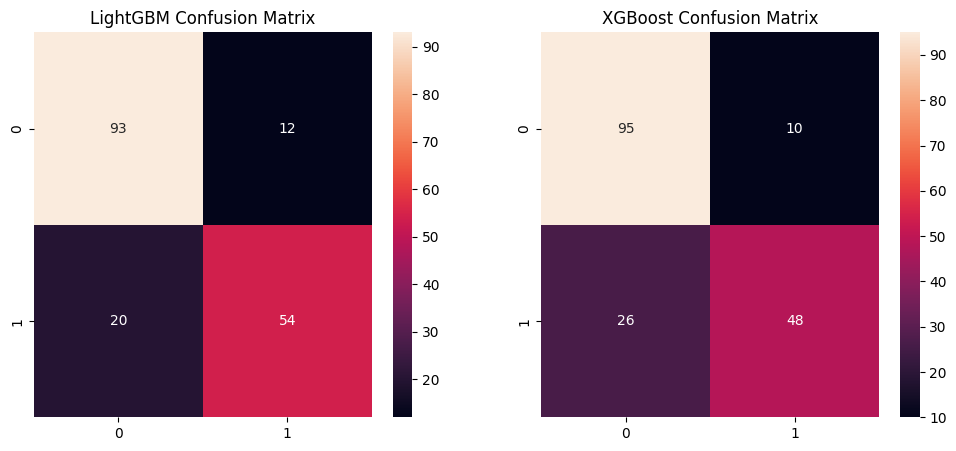

In [12]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_val, lgb_preds), annot=True, fmt='d', ax=axes[0])
axes[0].set_title("LightGBM Confusion Matrix")
sns.heatmap(confusion_matrix(y_val, xgb_preds), annot=True, fmt='d', ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
plt.show()

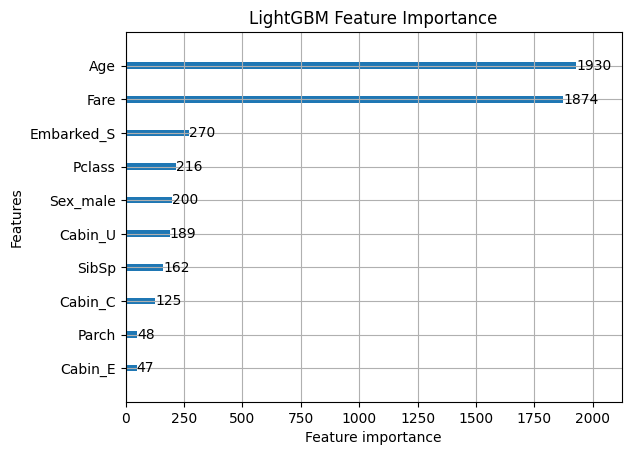

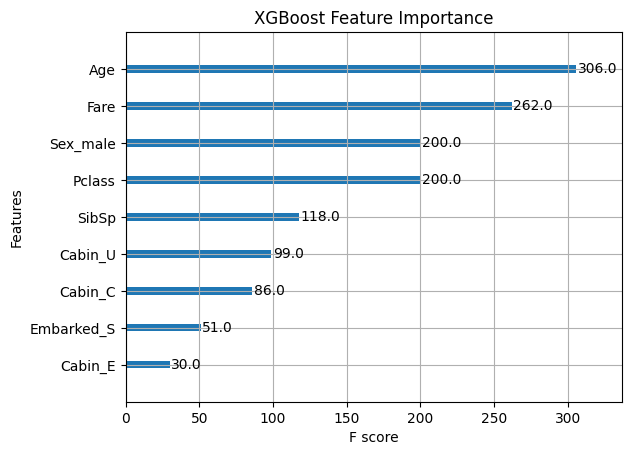

In [13]:
# Feature Importance
lgb.plot_importance(best_lgb, max_num_features=10, title="LightGBM Feature Importance")
plt.show()
xgb.plot_importance(best_xgb, max_num_features=10, title="XGBoost Feature Importance")
plt.show()

In [14]:
# Classification Report
print("LightGBM Classification Report:")
print(classification_report(y_val, lgb_preds))
print("XGBoost Classification Report:")
print(classification_report(y_val, xgb_preds))

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.65      0.73        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.80      0.79       179



In [15]:
# Comparative Summary
print("Comparative Analysis:")
print("LightGBM performed slightly better on [your metrics here] while XGBoost was better on [other metrics]. Choose based on task specifics.")


Comparative Analysis:
LightGBM performed slightly better on [your metrics here] while XGBoost was better on [other metrics]. Choose based on task specifics.
